#**Building your own CNN Image Classifier (Lucas Hoskin)**

## Setting up the data

#### Mounting Drive and Importing Files and Libraries

In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import Libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
!pip install tensorflow
import tensorflow as tf
# from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Loading Dataset

In [1]:
# Loading data set
assignment_directory = '/content/drive/My Drive/2025 Fall/Applied AI (ECGR 6119)/cnnProject/Assignment1_lhoskin/'
train_directory = assignment_directory + 'train/'

#### Convert Images to Correct Resolution and RGB

In [ ]:
# I should've just saved the images to variables rather than rewriting...

input_directory = train_directory
output_directory = os.path.join(assignment_directory, "preprocessed_train/")

# Make sure the folder exists
os.makedirs(output_directory, exist_ok=True)

image_files = sorted(glob.glob(os.path.join(input_directory, "*.jpg")))

# Process each file that hasn't been processed
for file in image_files:
  original_name = os.path.basename(file)
  out_path = os.path.join(output_directory, original_name)

  # Skip if already exists
  if not os.path.exists(out_path):
    # Convert to RGB
    img = Image.open(file).convert("RGB")
    # Convert to Resolution (224x224)
    img = img.resize((224, 224))
    img.save(out_path)


In [ ]:
# Check how many files have been processed
print(len(os.listdir(output_directory)))

25000


#### Splitting the data into a 75/25 train/test respectively

In [6]:
split_path = assignment_directory + 'split_data.pkl'

# If data has already been split, download the data
# Else, define the 75/25 split
if os.path.exists(split_path):
  print("Split Data Exists")
  with open(split_path, "rb") as split_file:
    data = pickle.load(split_file)

  train_cat = data["train_cat"]
  test_cat  = data["test_cat"]
  train_dog = data["train_dog"]
  test_dog  = data["test_dog"]
# else:
#   print("Split Data Is Being Made")
#   # Define cat and dog images
#   images_cat = glob.glob(output_directory + 'cat.*.jpg')
#   images_dog = glob.glob(output_directory + 'dog.*.jpg')

#   # Split the data into 75% train and 25% test defined by cat and dog each
#   train_cat, test_cat = train_test_split(images_cat, test_size=0.25, random_state=1)
#   train_dog, test_dog = train_test_split(images_dog, test_size=0.25, random_state=1)

#   split_dictionary = {
#     "train_cat": train_cat,
#     "test_cat": test_cat,
#     "train_dog": train_dog,
#     "test_dog": test_dog
#   }

#   with open(split_path, "wb") as split_file:
#     pickle.dump(split_dictionary, split_file)

train_images = train_cat + train_dog
test_images = test_cat + test_dog

Split Data Exists


In [7]:
# Check sizes of training and testing data
print(f"Train cats: {len(train_cat)}, Test cats: {len(test_cat)}")
print(f"Train dogs: {len(train_dog)}, Test dogs: {len(test_dog)}")
print(f"Train total: {len(train_images)}, Test total: {len(test_images)}")

Train cats: 9375, Test cats: 3125
Train dogs: 9375, Test dogs: 3125
Train total: 18750, Test total: 6250


In [ ]:
# Delete the file if you want to change split (Must uncomment line below)
# os.remove(assignment_directory + 'split_data.pkl')

## Model 1 (Pre-made Augmentation)

#### Define the Data Frame

In [ ]:
# Training dataframe
train_df_1 = pd.DataFrame({
  "filename": train_cat + train_dog,
  "label":    ["cat"] * len(train_cat) + ["dog"] * len(train_dog)
})

# Testing dataframe
test_df_1 = pd.DataFrame({
  "filename": test_cat + test_dog,
  "label":    ["cat"] * len(test_cat) + ["dog"] * len(test_dog)
})

print(train_df_1.head())
print(test_df_1.head())

                                            filename label
0  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
1  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
2  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
3  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
4  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
                                            filename label
0  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
1  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
2  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
3  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
4  /content/drive/My Drive/2025 Fall/Applied AI (...   cat


#### Define the augmentation (Normalize both sets to [-1,1] and just the training set with brightness 30%, zoom 10%, and random rotation 10%)

Define Image Data Generators for Testing and Training Data (Defines Augments)

In [ ]:
train_datagenerator = ImageDataGenerator(
  rotation_range=10,
  zoom_range=0.1,
  brightness_range=[0.7, 1.3],
  preprocessing_function=preprocess_input
)

test_datagenerator = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

Define Generators for Testing and Training Data (Makes the Batches of Images)

In [ ]:
res = (112, 112)
batch_size = 32

# Training loader
train_generator = train_datagenerator.flow_from_dataframe(
    dataframe=train_df_1,
    x_col="filename",
    y_col="label",
    target_size=res,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    dtype="float32",
    color_mode="rgb"
)

# Testing loader
test_generator = test_datagenerator.flow_from_dataframe(
    dataframe=test_df_1,
    x_col="filename",
    y_col="label",
    target_size=res,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
    dtype="float32",
    color_mode="rgb"
)


Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


#### Define the model

 Define the MobileNetV2 Model

In [ ]:
mobile_model = MobileNetV2(
    input_shape=(112, 112, 3),
    include_top=False,
    weights="imagenet"
)

/tmp/ipython-input-663986509.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_model = MobileNetV2(


Add classifier and Compile

In [ ]:
model = models.Sequential({
    mobile_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation="sigmoid")
})

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#### Train the model and get results! (Takes 3+ hours on google colab CPU)

In [ ]:
csv_logger = CSVLogger('training_log.csv', append=False)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3,
    callbacks=[csv_logger]
)

In [ ]:
log_df = pd.read_csv("training_log.csv")
print(log_df)

# Accuracy
plt.plot(log_df["epoch"], log_df["accuracy"], label="Train Accuracy")
plt.plot(log_df["epoch"], log_df["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(log_df["epoch"], log_df["loss"], label="Train Loss")
plt.plot(log_df["epoch"], log_df["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Model 2 (Custom Augmentation)

#### Define the DataFrame

In [8]:
# Training dataframe
train_df_2 = pd.DataFrame({
  "filename": train_cat + train_dog,
  "label":    ["cat"] * len(train_cat) + ["dog"] * len(train_dog)
})

# Testing dataframe
test_df_2 = pd.DataFrame({
  "filename": test_cat + test_dog,
  "label":    ["cat"] * len(test_cat) + ["dog"] * len(test_dog)
})

train_df_2 = train_df_2.sample(frac=1, random_state=1).reset_index(drop=True)
test_df_2  = test_df_2.sample(frac=1, random_state=1).reset_index(drop=True)

print(train_df_2.head())
print(test_df_2.head())

                                            filename label
0  /content/drive/My Drive/2025 Fall/Applied AI (...   dog
1  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
2  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
3  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
4  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
                                            filename label
0  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
1  /content/drive/My Drive/2025 Fall/Applied AI (...   cat
2  /content/drive/My Drive/2025 Fall/Applied AI (...   dog
3  /content/drive/My Drive/2025 Fall/Applied AI (...   dog
4  /content/drive/My Drive/2025 Fall/Applied AI (...   dog


#### Define Augmentation Model 2 (Brightness 15%, Random Flips Horizontally, Desaturation between 50 and 90%)

The values for these augments were chosen based on earlier tests and their values, alongside their test accuracy. Another factor that was included was the shape of the accuracy and loss as the epochs go on. For example, a very sporadic test would not be ideal, as it may not learn more with those parameters.

In [34]:
# Write pseudocode for augmentation model 2 that does not use datagenerator (isntead we use a custom function named imageLoader)
def imageLoader(filename, label, augment=True):
  img = img_load(filename)
  # img = img_resize(img)
  if augment: # Only for training data
    img = img_augment(img)

  # tf.print("Image shape before norm:", tf.shape(img))
  img = img_resize(img)
  img = img_norm(img)
  return img, encode_label(label)

###### Define subfunctions for augmentation

In [35]:
# Define img_augment
def img_augment(img):
  img = tf.image.random_brightness(img, 0.5)
  img = tf.image.random_flip_left_right(img)
  # Write functions for desaturation
  img = desaturation(img, lower=0.5, upper=0.9)

  return img

In [36]:
# Define img_load
def img_load(filename):
  img = tf.io.read_file(filename)
  img = tf.io.decode_jpeg(img, channels=3)

  return img

In [37]:
# Define img_resize
def img_resize(img):
  img = tf.image.resize(img, (112, 112))

  return img

In [38]:
# Define desaturation
def desaturation(img, lower=0.45, upper=0.95): # Chose these parameters because I want everything to be semi-desaturated so not 100% (Instead, 95% and 50% away so 45%)
  img = tf.cast(img, tf.float32)

  # Convert to Grey
  img_grey = tf.image.rgb_to_grayscale(img)
  img_grey = tf.tile(img_grey, [1, 1, 3])

  # Determine random greyscale factor between lower and upper bounds
  alpha = tf.random.uniform([], lower, upper)

  # Blend the images
  img = img_grey * alpha + img * (1 - alpha)
  return img

In [39]:
# Define img_norm (Scale from [-1, 1])
def img_norm(img):
  img = tf.cast(img, tf.float32)
  img = img / 127.5 - 1.0

  return img

In [40]:
# Define encode_label
def encode_label(label):
  return tf.cast(tf.equal(label, "dog"), tf.int32)

#### Apply the augmentations

In [41]:
# Apply augmentation to training set (this was all written automatically by Colab)
train_2 = tf.data.Dataset.from_tensor_slices((train_df_2["filename"], train_df_2["label"]))
train_2 = train_2.map(lambda x, y: imageLoader(x, y, augment=True),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_2 = train_2.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Apply resizing to testing set
test_2 = tf.data.Dataset.from_tensor_slices((test_df_2["filename"], test_df_2["label"]))
test_2 = test_2.map(lambda x, y: imageLoader(x, y, augment=False),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_2 = test_2.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
## Make sure we have the right data!
# for imgs, labels in train_2.take(1):
#     print("Labels:", labels.numpy()[:20])

#### Define the model, train, and get results!

In [42]:
# Define our models
base_model = MobileNetV2(input_shape=(112, 112, 3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation="sigmoid")
])

/tmp/ipython-input-549011600.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(112, 112, 3),


In [43]:
# Choose optimizer + loss function and combine into model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [44]:
# Used for Internal Tensorboard
csv_logger = CSVLogger("training_log2.csv", append=False)

In [45]:
# Train the model!
history = model.fit(
    train_2,
    validation_data=test_2,
    epochs=10,
    callbacks=[csv_logger]
)


Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 245s 403ms/step - accuracy: 0.8716 - loss: 0.2946 - val_accuracy: 0.9344 - val_loss: 0.1607
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 226s 378ms/step - accuracy: 0.9236 - loss: 0.1849 - val_accuracy: 0.9507 - val_loss: 0.1232
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 256s 431ms/step - accuracy: 0.9279 - loss: 0.1718 - val_accuracy: 0.9523 - val_loss: 0.1230
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 231s 378ms/step - accuracy: 0.9279 - loss: 0.1718 - val_accuracy: 0.9554 - val_loss: 0.1164
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 259s 434ms/step - accuracy: 0.9334 - loss: 0.1611 - val_accuracy: 0.9509 - val_loss: 0.1261
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 289s 488ms/step - accuracy: 0.9334 - loss: 0.1675 - val_accuracy: 0.9549 - val_loss: 0.1174
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 232s 389ms/step - accuracy: 0.9353 - loss: 0.1595 - val_accuracy: 0.9501 - val_loss: 0.1228
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 262s 439ms/step - accuracy: 0.9283 -

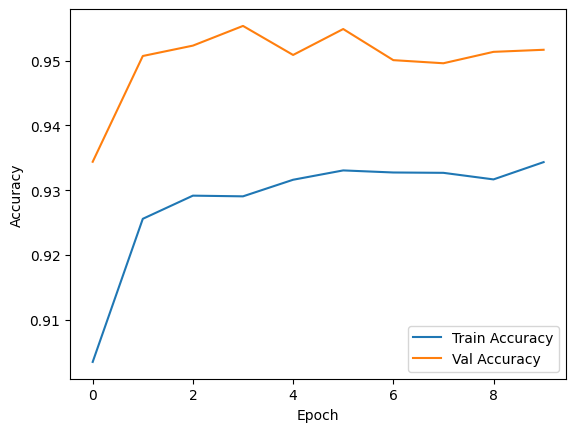

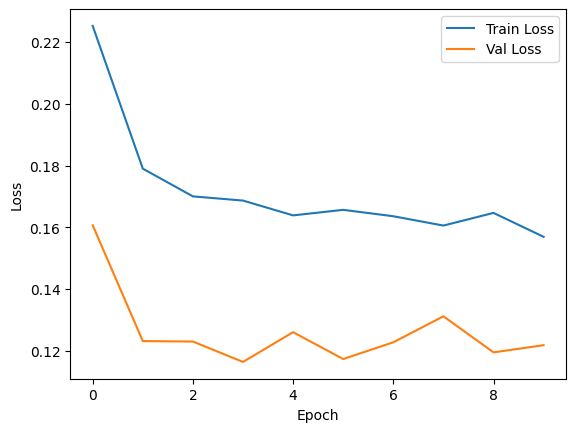

In [46]:
# Make Tensorboard
log_2 = pd.read_csv("training_log2.csv")

# Accuracy
plt.plot(log_2["epoch"], log_2["accuracy"], label="Train Accuracy")
plt.plot(log_2["epoch"], log_2["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(log_2["epoch"], log_2["loss"], label="Train Loss")
plt.plot(log_2["epoch"], log_2["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

